Мы использовали англоязычный источник, так как для него существуют более качественные предобученные модели.

In [1]:
pip install --upgrade accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 4.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.12.0
    Uninstalling accelerate-0.12.0:
      Successfully uninstalled accelerate-0.12.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torch transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 48.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd

Хотелось исследовать актуальные источники, поэтому вручную были скачаны последние 3200 твиттов бренда Dove. Эта компания была выбрана, так как она известна своими постами, затрагивающими социальные проблемы.
Мы бы хотели посмотреть на тематики, про которые пишут хорошо или плохо, поэтому искали именно такой бренд.
Большинство компаний пишут только про свои продукты, "нейтральных" постов большинство.

In [5]:
dataset = pd.read_excel("/kaggle/input/dove-dataset/Dove_user_tweets.xlsx")

Взяли самую популярную модельку с HF.

In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
checkpoint = 'cardiffnlp/twitter-roberta-base-sentiment'

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

In [13]:
from transformers import pipeline

text_classifier = pipeline(task='text-classification', model=model, tokenizer=tokenizer, device=0)

In [8]:
pip install xformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 11.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 904.8 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 54.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 85.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 16.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 12.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 6.9 MB/s eta 0:00:0000:0100:01
     ━━━━

In [11]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [14]:
def apply_pipeline(text):
    return text_classifier(text)[0]['label']
  
dataset['preds'] = dataset.Text.progress_apply(apply_pipeline)

  0%|          | 0/3198 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1080: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [15]:
dataset = dataset[['Text', 'preds', 'Created At', 'Favorites', 'Retweets', 'Language', 'Tweet Type', 'Hashtags', 'Mentions']]

In [16]:
dataset = dataset.replace({'LABEL_2': 'positive', 'LABEL_1': 'neutral', 'LABEL_0': 'negative'})

Как видно ниже, Dove чаще всего высказывается в позитивном или нейтральном ключах и очень редко в негативных. Посмотрим на позитивные и негативные поближе

In [108]:
dataset.preds.value_counts(normalize=True)

positive    0.748906
neutral     0.227017
negative    0.024078
Name: preds, dtype: float64

In [109]:
dataset['textlen'] = dataset.Text.apply(lambda x: len(x))

In [113]:
dataset.groupby('preds')['preds', 'textlen'].mean('textlen')

,textlen
preds,
negative,168.064935
neutral,111.774105
positive,72.353236


И если посмотреть на распределение длин текстов, то негативно бренд высказывается максимально подробно.

Позитивно бренд высказывается в ретвиттах других пользователей, благодаря или хваля их

In [115]:
dataset[dataset.preds == 'positive'].sample(n=10).Text.values

array(['@BamseyDigital ❤️❤️',
       '@DidySeanySheetz So happy you love our beauty bar!',
       '@HRRYB00BS The feeling is mutual 😌💗',
       '@Newsie2 Thank you for sharing 💕💕', '@aenxdxrr hiiiiii 😙',
       '@KamonikaThomps1 happy to be part of ur routine',
       '@BIGGMAMA222 😙❤️🥰🙌',
       '@GMarytonia our beauty bar looks so cute here ♥️',
       "@HavocSunsets hehe what's your favorite scent? ☺️",
       '@uh8mk_ we are happy to be part of your routine! 🤗'], dtype=object)

Негативно бренд отвечает на негативных фидбек клиентов или про дискриминацию по внешности или расе

In [116]:
dataset[dataset.preds == 'negative'].sample(n=10).Text.values

array(["@toriiibenton @itsJadyn we're not going anywhere 🥺",
       '@PopCultureBits Although benzene is not an ingredient in Unilever’s products, it can sometimes occur at trace levels due to its natural presence in certain raw materials. An internal investigation found elevated levels from the propellant in the recalled products. Visit https://t.co/opwKysGTAo.',
       '@Teeshhbby_ Hi there, we’re so sorry to hear you were disappointed. Please DM us, so we can make this right.',
       "@NerdzAffiliator We're so sorry to see this - please send us a DM when you get the chance!",
       "@LMB1313 We're sorry to hear you had this experience! Please DM us when you get the chance.",
       '@LaillaTorvorn Appearance-based discrimination is defined as the unjust, prejudicial treatment of somebody purely based on their appearance. Appearance-based discrimination can be based on any physical feature of a person.',
       '- Promotions\u200b\n- Respect\u200b\n- Your personal space \u200b\n\u2

Мы использует key words extractor, обученный на sentence transformers.

In [18]:
pip install keybert[use]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=0e9516959bc987244e0dec71420c72c13875d82782b7c718743a877aa0d1b7bd
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
  Created wheel for keybert: filename=keybert-0.7.0-py3-none-any.whl size=23798 sha256=a1ad6eeeb5224561d85c9a3a65119e1ec171de5f8c2347123a3fe13aa3f047f0
  Stored in directory: /root/.cache/pip/wheels/66/8d/e6/b0e2f8d883b0fd5181

In [19]:
from keybert import KeyBERT

kw_model = KeyBERT('all-mpnet-base-v2')

In [20]:
def apply_extr(text):
    preds = kw_model.extract_keywords(text)

    return [text[0] for text in preds]
  
dataset['extr'] = dataset.Text.progress_apply(apply_extr)

  0%|          | 0/3198 [00:00<?, ?it/s]

In [21]:
pip install summa

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54410 sha256=cbf2b04b81bed55e065037ee38d318068a4178d54df9706df9a27ef3bfc1987d
  Stored in directory: /root/.cache/pip/wheels/4a/ca/c5/4958614cfba88ed6ceb7cb5a849f9f89f9ac49971616bc919f
Successfully built summa
Note: you may need to restart the kernel to use updated packages.


Для разнообразия был использован другой метод выделения ключевых слов

In [22]:
from summa import keywords
def apply_rank_extr(text):
    preds = keywords.keywords(text, scores=True)

    return [text[0] for text in preds]
  
dataset['extr_rank'] = dataset.Text.progress_apply(apply_rank_extr)

  0%|          | 0/3198 [00:00<?, ?it/s]

In [23]:
pip install scikit-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.


SBert лучше отрабатывает на негативах

In [88]:
from collections import Counter
Counter(neg_extr).most_common(10)

[('discrimination', 22),
 ('appearance', 17),
 ('dm', 16),
 ('prejudicial', 13),
 ('hear', 12),
 ('sorry', 12),
 ('send', 10),
 ('unjust', 10),
 ('disappointed', 9),
 ('hair', 9)]

In [90]:
Counter(neg_extr_rank).most_common(10)

[('purely based', 10),
 ('hi', 9),
 ('hair', 2),
 ('new shape', 2),
 ('retailers', 2),
 ('retailer', 2),
 ('rt', 2),
 ('products', 2),
 ('signature', 2),
 ('frydelewa', 1)]

Примерно одинаково на позитивах

In [85]:
Counter(pos_extr).most_common(10)

[('thank', 382),
 ('sharing', 315),
 ('love', 296),
 ('glad', 144),
 ('bestie', 112),
 ('happy', 101),
 ('katheri83183932', 99),
 ('thanks', 98),
 ('dove', 85),
 ('products', 83)]

In [91]:
Counter(pos_extr_rank).most_common(10)

[('hi', 153),
 ('thanks', 40),
 ('thank', 22),
 ('new', 13),
 ('smell', 12),
 ('formula', 9),
 ('reached', 9),
 ('amp', 8),
 ('body', 7),
 ('linkedin', 7)]

И пожалуй лучше на нейтральных (тут больше уникальных терминов)

In [93]:
Counter(neutral_extr).most_common(10)

[('dm', 137),
 ('sorry', 115),
 ('send', 89),
 ('hear', 71),
 ('dove', 62),
 ('scent', 55),
 ('products', 51),
 ('unilever', 49),
 ('help', 39),
 ('recalled', 37)]

In [92]:
Counter(neutral_extr_rank).most_common(10)

[('hi', 122),
 ('unilever', 35),
 ('reached', 10),
 ('reaching', 9),
 ('team', 7),
 ('hair', 6),
 ('retailer', 6),
 ('retailers set', 6),
 ('recalled', 6),
 ('thecrownact', 4)]

Чтобы определить, в какие слова не просто чаще встречаются в твиттах определенной тональности, но и более уникальны для каждой из них, мы применили tfidf, где в качестве каждого документа представлена строчка из всех ключевых слов по тональности.

In [129]:
neutral_extr = []
for l in dataset[dataset.preds == 'neutral'].extr.values:
    neutral_extr.extend(l)

neg_extr = []
for l in dataset[dataset.preds == 'negative'].extr.values:
    neg_extr.extend(l)

pos_extr = []
for l in dataset[dataset.preds == 'positive'].extr.values:
    pos_extr.extend(l)

neutral_string = ' '.join(neutral_extr)
neg_string = ' '.join(neg_extr)
pos_string = ' '.join(pos_extr)

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf = TfidfVectorizer(use_idf=True, norm='l2')
tfidf_mat = tfidf.fit_transform([pos_string, neg_string, neutral_string])

def get_top_tf_idf_words(response, top_n=10, feature_names=None):
    sorted_nzs = np.argsort(response.data)[:-(top_n+1):-1]
    return feature_names[response.indices[sorted_nzs]]
  
feature_names = np.array(tfidf.get_feature_names_out())


res = [get_top_tf_idf_words(response, 10, feature_names) for response in tfidf_mat]

In [95]:
neutral_extr_rank = []
for l in dataset[dataset.preds == 'neutral'].extr_rank.values:
    neutral_extr_rank.extend(l)

neg_extr_rank = []
for l in dataset[dataset.preds == 'negative'].extr_rank.values:
    neg_extr_rank.extend(l)

pos_extr_rank = []
for l in dataset[dataset.preds == 'positive'].extr_rank.values:
    pos_extr_rank.extend(l)
 

neutral_string_rank = ' '.join(neutral_extr_rank)
neg_string_rank = ' '.join(neg_extr_rank)
pos_string_rank = ' '.join(pos_extr_rank)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_rank = TfidfVectorizer(use_idf=True, norm='l2')
tfidf_mat_rank = tfidf_rank.fit_transform([pos_string_rank, neg_string_rank, neutral_string_rank])
  
feature_names_rank = np.array(tfidf_rank.get_feature_names_out())

res_rank = [get_top_tf_idf_words(response, 10, feature_names=feature_names_rank) for response in tfidf_mat_rank]
for i in res_rank:
    print(i, '\n')

['hi' 'thanks' 'thank' 'smell' 'formula' 'new' 'feedback' 'linkedin'
 'reached' 'love'] 

['based' 'purely' 'hi' 'prejudicial' 'shape' 'new' 'discrimination'
 'signature' 'retailer' 'products'] 

['hi' 'unilever' 'reached' 'reaching' 'set' 'recalled' 'team' 'retailers'
 'retailer' 'safety'] 



In [80]:
for i in res:
    print(i, '\n')

['sharing' 'thank' 'love' 'glad' 'happy' 'thanks' 'bestie'
 'katheri83183932' 'amazing' 'smaller'] 

['prejudicial' 'discrimination' 'appearance' 'unjust' 'dm' 'hear' 'sorry'
 'psa' 'send' 'hair'] 

['dm' 'sorry' 'send' 'hear' 'dove' 'scent' 'products' 'caution' 'unilever'
 'recalled'] 



Мы решили, что tfidf менее информативен чем простой Counter (по крайней мере на этих твиттах). Но как возможный метод может пригодится в будущем

Построим облака слов, чтобы наглядно посмотреть на полученные данные

In [44]:
pip install wordcloud

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.


In [61]:
import matplotlib.pyplot as plt

%matplotlib inline

Как было описано выше, извинения перед пользователями (dm=direct message) и дискриминация по внешности являются основными темами бренда, котоыре определились как негативные (хотя тут мы не совсем согласны, так как извинения это не совсем негативное)

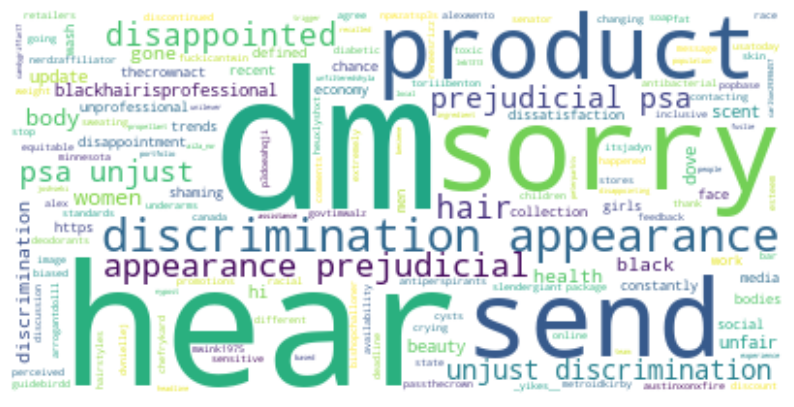

In [97]:
from wordcloud import WordCloud
plt.figure(figsize=(10,6))

wc = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='firebrick')
wc.generate(' '.join(neg_extr))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

В позитивном ключе компания благодарит пользователей, некоторых (besite & kather...) особенно часто.

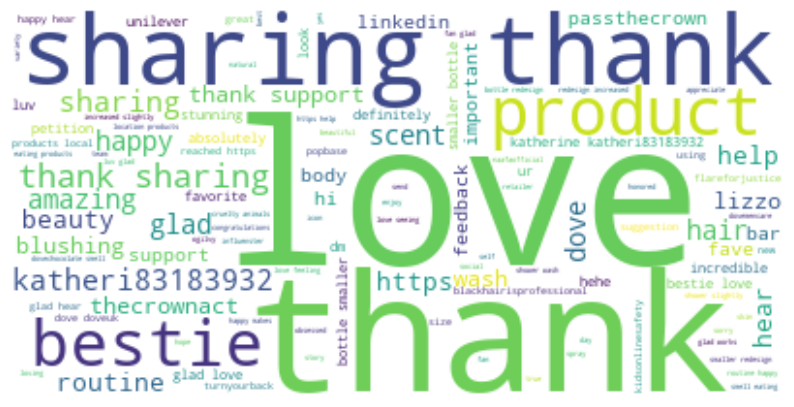

In [102]:
plt.figure(figsize=(10,6))
wc = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='firebrick')
wc.generate(' '.join(pos_extr))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Нейтрально компания отзывается о своих продуктах (product, unilever), но в целом этот класс довольно спутан с позитивным. 

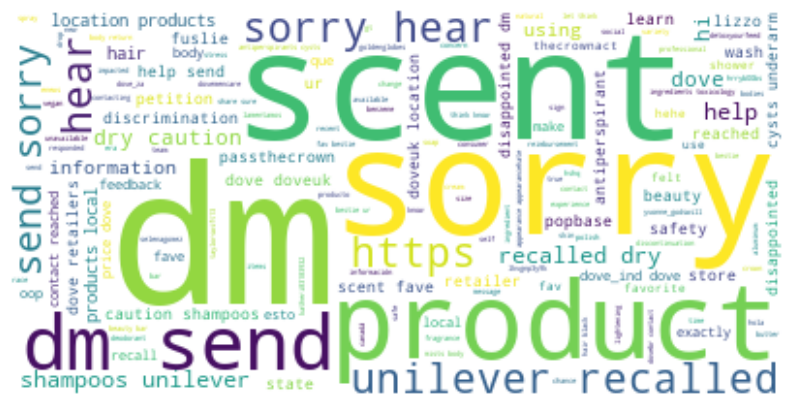

In [103]:
plt.figure(figsize=(10,6))
wc = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='firebrick')
wc.generate(' '.join(neutral_extr))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [118]:
# tfidf = TfidfVectorizer(use_idf=True, norm='l2')
# tfidf_mat
# vecs = vectorizer.fit_transform(corpus)
feature_names = tfidf.get_feature_names_out()
dense = tfidf_mat.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names)
df

,0xpriyanka,10,100,1025theblock,10alyx17,13oz,16,1barbienek,1chanel__,1chrisdewet,...,zamaan_qureshi,zan_toka,zariireginaee,zeedefineass,zeeej_m,zeesh2,zemirah,ziniichuks,zxz9kijlu5,zyahnab
0,0.003381,0.001286,0.006763,0.001691,0.000000,0.001691,0.0000,0.001691,0.003381,0.001691,...,0.000000,0.001691,0.000000,0.002572,0.001691,0.001691,0.001691,0.001691,0.001691,0.001691
1,0.000000,0.022968,0.000000,0.000000,0.000000,0.000000,0.0302,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.005829,0.000000,0.0000,0.000000,0.000000,0.000000,...,0.005829,0.000000,0.005829,0.004433,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Однако если мы построим облако слов на TFIDF, значения получатся гораздо более чистыми (для негативов)

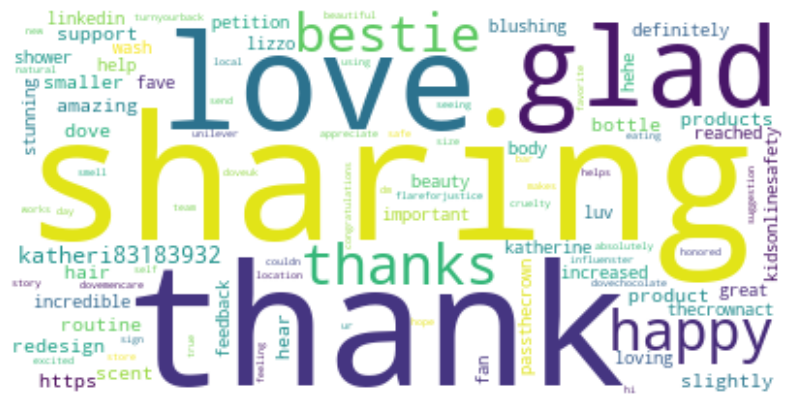

In [126]:
plt.figure(figsize=(10,6))
wc = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='firebrick')
wc.generate_from_frequencies(df.T[0])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

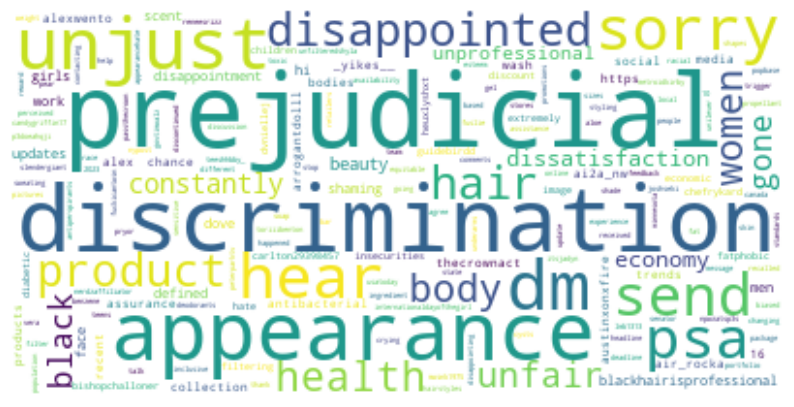

In [127]:
plt.figure(figsize=(10,6))
wc = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='firebrick')
wc.generate_from_frequencies(df.T[1])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()